<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Single Stock Trading Using Ensemble Strategy

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [104]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [105]:
import warnings
warnings.filterwarnings("ignore")

In [106]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [107]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [108]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [109]:
test_ticket = ['AAPL']

In [110]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = test_ticket).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3522, 8)


In [111]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470741,493729600,AAPL,0
1,2010-01-05,7.664286,7.699643,7.616071,6.481928,601904800,AAPL,1
2,2010-01-06,7.656429,7.686786,7.526786,6.378825,552160000,AAPL,2
3,2010-01-07,7.562500,7.571429,7.466071,6.367033,477131200,AAPL,3
4,2010-01-08,7.510714,7.571429,7.466429,6.409362,447610800,AAPL,4


In [112]:
df.tail()

,date,open,high,low,close,volume,tic,day
3517,2023-12-22,195.179993,195.410004,192.970001,193.353287,37122800,AAPL,4
3518,2023-12-26,193.610001,193.889999,192.830002,192.803986,28919300,AAPL,1
3519,2023-12-27,192.490005,193.500000,191.089996,192.903839,48087700,AAPL,2
3520,2023-12-28,194.139999,194.660004,193.169998,193.333298,34049900,AAPL,3
3521,2023-12-29,193.899994,194.399994,191.729996,192.284637,42628800,AAPL,4


In [113]:
df.shape

(3522, 8)

In [114]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470741,493729600,AAPL,0
1,2010-01-05,7.664286,7.699643,7.616071,6.481928,601904800,AAPL,1
2,2010-01-06,7.656429,7.686786,7.526786,6.378825,552160000,AAPL,2
3,2010-01-07,7.562500,7.571429,7.466071,6.367033,477131200,AAPL,3
4,2010-01-08,7.510714,7.571429,7.466429,6.409362,447610800,AAPL,4


In [115]:
len(df.tic.unique())

1

In [116]:
df.tic.value_counts()

tic
AAPL    3522
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [117]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [118]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [119]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
429,2011-09-15,13.979643,14.059286,13.925000,11.881422,417818800,AAPL,3,0.108890,12.073095,10.838246,56.765574,134.465092,0.568691,11.403393,11.214767,0.270231
3162,2022-07-27,152.580002,157.330002,152.160004,155.246262,78620700,AAPL,2,3.239637,157.321950,134.723985,55.503050,127.880941,23.186162,142.237611,143.991847,3.254549
1336,2015-04-27,33.077499,33.282501,32.787498,29.764297,387816800,AAPL,0,0.282018,29.411167,27.572260,60.547689,290.500583,34.478828,28.408281,28.267057,1.451633
2152,2018-07-23,47.669998,47.990002,47.389999,45.599171,63957600,AAPL,0,0.315203,46.330792,43.261180,56.796414,69.347239,10.840701,44.818276,44.450211,0.000273
41,2010-03-04,7.474286,7.532857,7.451071,6.370965,366041200,AAPL,3,0.054877,6.411109,5.759304,54.178601,144.225111,19.789569,6.076428,6.163468,0.000000


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [120]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension # remain_capital + (prices_of_stocks+amount_of_holdings) + indicators
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 11


In [121]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [122]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [123]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [124]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  14.172279090144063
======Model training from:  2010-01-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_4
----------------------------------------
| time/                 |              |
|    fps                | 763          |
|    iterations         | 100          |
|    time_elapsed       | 0            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -1.5         |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -0.00877     |
|    reward             | 0.0033626838 |
|    std                | 1.08         |
|    value_loss         | 6.79e-05     |
----------------------------------------
--------------------------------------
| time/          

In [125]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,DDPG,-0.066155,-0.064834,0.0
1,189,2021-04-06,2021-07-06,DDPG,0.369875,0.356605,0.369875
2,252,2021-07-06,2021-10-04,A2C,-0.132435,-0.13904,-0.13678
3,315,2021-10-04,2022-01-03,DDPG,0.386822,0.379058,0.386822
4,378,2022-01-03,2022-04-04,PPO,-0.390841,0.097004,0.0
5,441,2022-04-04,2022-07-06,PPO,-0.175468,-0.106816,-0.126724
6,504,2022-07-06,2022-10-04,DDPG,-0.2319,-0.25987,-0.2319
7,567,2022-10-04,2023-01-04,DDPG,-0.214018,-0.192764,0.0
8,630,2023-01-04,2023-04-05,PPO,0.473132,0.484741,0.0
9,693,2023-04-05,2023-07-07,A2C,0.510989,0.478223,0.0


### Save model as ONNX file ###

In [151]:
import torch as th
import torch.onnx
from stable_baselines3 import DDPG

In [155]:
train_ddpg = ensemble_agent.get_model('ddpg',ensemble_agent.train_env)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [162]:
train_ddpg.save("test_one_ticket_ddpg")

In [156]:
# class OnnxablePolicy(th.nn.Module):
#     def __init__(self, actor: th.nn.Module):
#         super().__init__()
#         self.actor = actor

#     def forward(self, observation: th.Tensor) -> th.Tensor:
#         # NOTE: You may have to postprocess (unnormalize) actions
#         # to the correct bounds (see commented code below)
#         return self.actor(observation, deterministic=True)

In [161]:
# onnxable_model = OnnxablePolicy(train_ddpg.policy.actor)

# observation_size = train_ddpg.observation_space.shape
# dummy_input = th.randn(1, *observation_size)
# th.onnx.export(
#     onnxable_model,
#     dummy_input,
#     "test_one_ticket_ddpg.onnx",
#     opset_version=17,
#     input_names=["input"],
# )

TypeError: Actor.forward() got an unexpected keyword argument 'deterministic'

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [126]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [127]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,pd.DataFrame(temp)],ignore_index=True)
    # df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.14331618503123894


In [128]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.0,2021-04-06,NaN,2021-04-06
1,1000000.0,2021-04-07,0.0,2021-04-07
2,1000000.0,2021-04-08,0.0,2021-04-08
3,1000000.0,2021-04-09,0.0,2021-04-09
4,1000000.0,2021-04-12,0.0,2021-04-12


<Axes: >

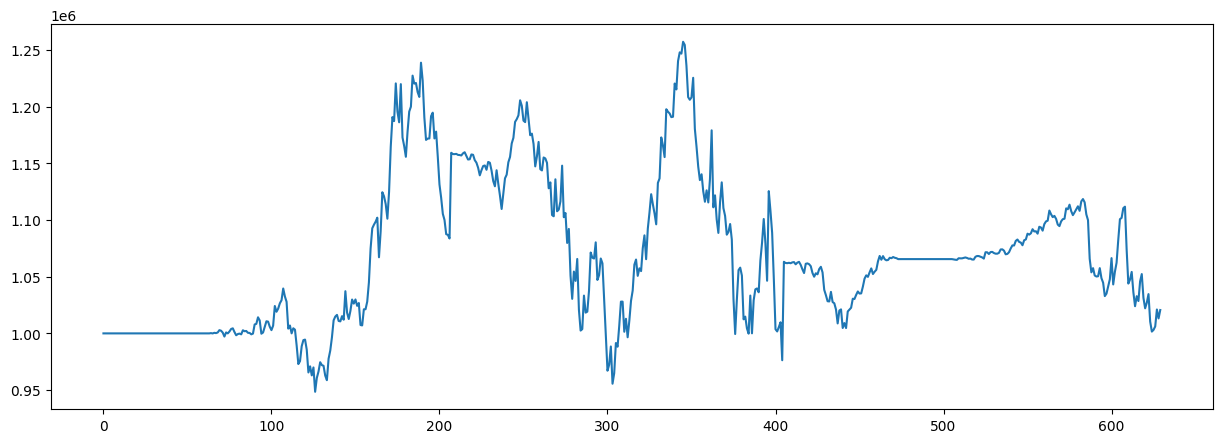

In [129]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [130]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.008191
Cumulative returns     0.020604
Annual volatility      0.210057
Sharpe ratio           0.143316
Calmar ratio           0.035828
Stability              0.048689
Max drawdown          -0.228629
Omega ratio            1.031278
Sortino ratio          0.208825
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.978980
Daily value at risk   -0.026345
dtype: float64


In [131]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (629, 8)
Annual return         -0.005147
Cumulative returns    -0.012799
Annual volatility      0.155208
Sharpe ratio           0.044257
Calmar ratio          -0.023460
Stability              0.075724
Max drawdown          -0.219408
Omega ratio            1.007529
Sortino ratio          0.061979
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.987304
Daily value at risk   -0.019527
dtype: float64


In [132]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2021-04-06  1.000000e+06
1    2021-04-07  1.000479e+06
2    2021-04-08  1.002194e+06
3    2021-04-09  1.011079e+06
4    2021-04-12  1.009427e+06
..          ...           ...
625  2023-09-28  1.007063e+06
626  2023-09-29  1.002311e+06
627  2023-10-02  1.000093e+06
628  2023-10-03  9.872014e+05
629  2023-10-04           NaN

[630 rows x 2 columns]
df_dji:                       dji
date                    
2021-04-06  1.000000e+06
2021-04-07  1.000479e+06
2021-04-08  1.002194e+06
2021-04-09  1.011079e+06
2021-04-12  1.009427e+06
...                  ...
2023-09-28  1.007063e+06
2023-09-29  1.002311e+06
2023-10-02  1.000093e+06
2023-10-03  9.872014e+05
2023-10-04           NaN

[630 rows x 1 columns]


### Compare with buy-and-hold strategy
compare with itself

In [133]:
print("==============Get Buy&Hold Stats===========")
df_hold_ = get_baseline(
        ticker="AAPL", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_hold_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Buy&Hold Stats===========
Shape of DataFrame:  (629, 8)
Annual return          0.139779
Cumulative returns     0.386201
Annual volatility      0.282198
Sharpe ratio           0.605186
Calmar ratio           0.452172
Stability              0.325460
Max drawdown          -0.309128
Omega ratio            1.107078
Sortino ratio          0.880937
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.953207
Daily value at risk   -0.034876
dtype: float64


In [134]:
print(df_hold.head())

                    hold
date                    
2021-04-06  1.000000e+06
2021-04-07  1.013390e+06
2021-04-08  1.032882e+06
2021-04-09  1.053799e+06
2021-04-12  1.039854e+06


In [135]:
df_hold = pd.DataFrame()
df_hold['date'] = df_account_value['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
print("df_hold: ", df_hold)
df_hold.to_csv("df_hold.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
df_hold.to_csv("df_hold+.csv")

df_account_value.to_csv('df_account_value.csv')

df_hold:             date          hold
0    2021-04-06  1.000000e+06
1    2021-04-07  1.013390e+06
2    2021-04-08  1.032882e+06
3    2021-04-09  1.053799e+06
4    2021-04-12  1.039854e+06
..          ...           ...
625  2023-09-28  1.372452e+06
626  2023-09-29  1.376633e+06
627  2023-10-02  1.397056e+06
628  2023-10-03  1.386201e+06
629  2023-10-04           NaN

[630 rows x 2 columns]
df_hold:                      hold
date                    
2021-04-06  1.000000e+06
2021-04-07  1.013390e+06
2021-04-08  1.032882e+06
2021-04-09  1.053799e+06
2021-04-12  1.039854e+06
...                  ...
2023-09-28  1.372452e+06
2023-09-29  1.376633e+06
2023-10-02  1.397056e+06
2023-10-03  1.386201e+06
2023-10-04           NaN

[630 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-01-04
1    2021-01-05
2    2021-01-06
3    2021-01-07
4    2021-01-08
..          ...
748  2023-12-22
749  2023-12-26
750  2023-12-27
751  2023-12-28
752  2023-12-29

[753 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2021-04-06  1.000000e+06
2021-04-07  1.000000e+06
2021-04-08  1.000000e+06
2021-04-09  1.000000e+06
2021-04-12  1.000000e+06
...                  ...
2023-09-28  1.003095e+06
2023-09-29  1.006150e+06
2023-10-02  1.021075e+06
2023-10-03  1.013209e+06
2023-10-04  1.020604e+06

[630 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2021-04-06  1.000000e+06  1.000000e+06
2021-04-07  1.000000e+06  1.000479e+06
2021-04-08  1.000000e+06  1.002194e+06
2021-04-09  1.000000e+06  1.011079e+06
2021-04-12  1.000000e+06  1.009427e+06
...       

<Figure size 1500x500 with 0 Axes>

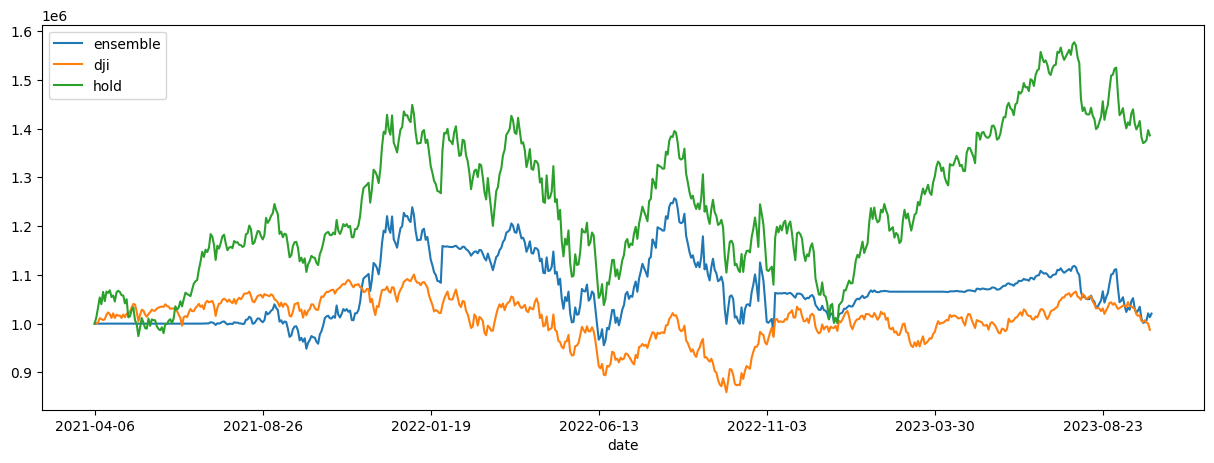

In [136]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)

print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)

print("==============Compare to Buy&Hold===========")
result = pd.merge(result, df_hold, left_index=True, right_index=True)
print("result_hold: ", result)

result.to_csv("result.csv")
result.columns = ['ensemble', 'dji', 'hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();